https://github.com/vivek081166/raw-audio-deep-learning/blob/master/constants.py

import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
# from constants import DATA_AUDIO_DIR

DATA_AUDIO_DIR = './test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()
TARGET_SR = 8000
AUDIO_LENGTH = 100000

def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


# def del_folder(path):
#     try:
#         rmtree(path)
#     except:
#         pass


# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
# mkdir_p(OUTPUT_DIR_TRAIN)
# mkdir_p(OUTPUT_DIR_TEST)

order = 0
class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[18:-6])


def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=target_sr, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():
    DATA_AUDIO_DIR = './test_train_data'
    list_dir = os.listdir(DATA_AUDIO_DIR)
    list_dir.sort()
#     TARGET_SR = 16000
#     AUDIO_LENGTH = 200000
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_DIR, '**/**.wav'), recursive=True)):
#         print(i, wav_filename)
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        if original_length < AUDIO_LENGTH:
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
        elif original_length > AUDIO_LENGTH:
            audio_buf = audio_buf[20000:AUDIO_LENGTH+20000]
            print('CUT New length =', len(audio_buf))

        output_folder = OUTPUT_DIR_TRAIN
        if wav_filename[-5:] == '5.wav':
            output_folder = OUTPUT_DIR_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[18:-4]).replace('/', '_') + '.pkl')
#         TARGET_SR = 16000
        out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}
        print("-----------------")
        print(out)
        with open(output_filename, 'wb') as w:
            pickle.dump(out, w)


if __name__ == '__main__':
    convert_data()

In [1]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow import convert_to_tensor
import numpy as np
import pickle
import os
from glob import glob

AUDIO_LENGTH = 100000
OUTPUT_DIR = './output_ver1'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()
# TARGET_SR = 16000

class_ids = {list_dir[i]: i for i in range(len(list_dir))}
def m5(num_classes):
    print("!!!!!!!!", num_classes)
    print('Using Model M5')
    m = Sequential()
    m.add(Conv1D(128,
                 input_shape=[AUDIO_LENGTH, 1],
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(128,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Conv1D(512,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4, strides=None))
    m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
    m.add(Dense(num_classes, activation='softmax'))
    return m


def get_data(file_list):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
#         print("Predict file name : ", filename)
        load_into(filename, x, y)
    return np.array(x), np.array(y)



num_classes = len(list_dir)
print(num_classes)
model = m5(num_classes=len(list_dir))

if model is None:
    exit('Something went wrong!!')

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl'))
x_tr, y_tr = get_data(train_files)
y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
x_te, y_te = get_data(test_files)
y_te = to_categorical(y_te, num_classes=num_classes)

print('x_tr.shape =', x_tr.shape)
print('y_tr.shape =', y_tr.shape)
print('x_te.shape =', x_te.shape)
print('y_te.shape =', y_te.shape)
print(type(x_te))

# if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
batch_size = 128
history = model.fit(x=x_tr, y=y_tr, batch_size=16, epochs=100, verbose=2, shuffle=True, validation_data=(x_te, y_te), callbacks=[reduce_lr])
    
# epoch 500 audio_length 10000 min_lr 0.0001 sr 8000 batch_size 16 : val_acc 0.73
# epoch 500 audio_length 10000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.77(0.83)
# epoch 50 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.90
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.93
# epoch 100 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 32 : val_acc 0.89(0.90) predict 0.75
# epoch 150 audio_length 20000 min_lr 0.00005 sr 8000 batch_size 16 : val_acc 0.91 predict 0.75

125
!!!!!!!! 125
Using Model M5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25000, 128)        10368     
_________________________________________________________________
batch_normalization (BatchNo (None, 25000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 25000, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6250, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6250, 128)         49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6250, 128)         512       
_________________________________________________________________
activation_1 (Activation

Epoch 51/100
954/954 - 6s - loss: 0.0860 - accuracy: 0.9790 - val_loss: 0.1065 - val_accuracy: 0.9748
Epoch 52/100

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
954/954 - 6s - loss: 0.0834 - accuracy: 0.9822 - val_loss: 0.1049 - val_accuracy: 0.9748
Epoch 53/100
954/954 - 6s - loss: 0.0825 - accuracy: 0.9801 - val_loss: 0.1049 - val_accuracy: 0.9748
Epoch 54/100
954/954 - 6s - loss: 0.0819 - accuracy: 0.9811 - val_loss: 0.1056 - val_accuracy: 0.9748
Epoch 55/100
954/954 - 6s - loss: 0.0811 - accuracy: 0.9811 - val_loss: 0.1038 - val_accuracy: 0.9748
Epoch 56/100
954/954 - 6s - loss: 0.0813 - accuracy: 0.9769 - val_loss: 0.1041 - val_accuracy: 0.9748
Epoch 57/100
954/954 - 6s - loss: 0.0797 - accuracy: 0.9822 - val_loss: 0.1047 - val_accuracy: 0.9748
Epoch 58/100
954/954 - 6s - loss: 0.0806 - accuracy: 0.9811 - val_loss: 0.1030 - val_accuracy: 0.9790
Epoch 59/100
954/954 - 6s - loss: 0.0794 - accuracy: 0.9843 - val_loss: 0.1030 - val_accuracy: 0.9790
E

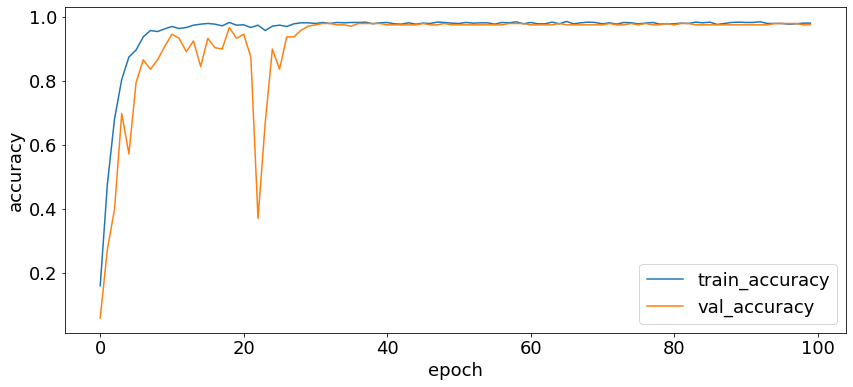

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.rc('font', size=18)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
from constants import DATA_AUDIO_DIR
DATA_AUDIO_VAL_DIR = '../test_val_data'
OUTPUT_DIR_VAL_TRAIN = './output_val/train'
OUTPUT_DIR_VAL_TEST = './output_val/test'


DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[18:-6])


def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


# def del_folder(path):
#     try:
#         rmtree(path)
#     except:
#         pass


# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
# mkdir_p(OUTPUT_DIR_TRAIN)
# mkdir_p(OUTPUT_DIR_TEST)

class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[16:-6].replace('/', ''))


def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=target_sr, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():
    DATA_AUDIO_DIR = '../test_train_data'
    list_dir = os.listdir(DATA_AUDIO_VAL_DIR)
    list_dir.sort()
    print(list_dir)
    AUDIO_LENGTH = 100000
    TARGET_SR = 8000
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        print(i, wav_filename)
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        if original_length < AUDIO_LENGTH:
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
        elif original_length > AUDIO_LENGTH:
            audio_buf = audio_buf[20000:AUDIO_LENGTH+20000]
#             audio_buf = audio_buf[10000:AUDIO_LENGTH+10000]
            print('CUT New length =', len(audio_buf))

        output_folder = OUTPUT_DIR_VAL_TRAIN
#         if i % 5 == 0:
#             output_folder = OUTPUT_DIR_VAL_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[16:-4]).replace('/', '_') + '.pkl')

        out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}
        print("-----------------")
        print(out)
        with open(output_filename, 'wb') as w:
            pickle.dump(out, w)


if __name__ == '__main__':
    convert_data()

In [3]:
from sklearn.metrics import accuracy_score

DATA_AUDIO_VAL_DIR = '../test_val_data'
OUTPUT_DIR_VAL_TRAIN = './output_val_ver1/train'
OUTPUT_DIR_VAL_TEST = './output_val_ver1/test'

train_files_1 = glob(os.path.join(OUTPUT_DIR_VAL_TRAIN, '**.pkl'))
train_files_1.sort()

x_tr_1, y_tr_1 = get_data(train_files_1)
print('y_tr_1 : ', y_tr_1)

y_tr_12 = to_categorical(y_tr_1, num_classes=num_classes)

pred_out = model.predict(x_tr_1)

real =[]
pred_out_idex=[]

val_class_names = os.listdir(DATA_AUDIO_VAL_DIR)
print(val_class_names)
# val_class_names.sort()

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

j = 0
for i,pred in zip(range(0, len(pred_out)), pred_out) :
    print("Predict :",list_dir[np.argmax(pred)], ", Real :", list_dir[y_tr_1[i]], ", 값: ",np.max(pred))
    real.append(list_dir.index(list_dir[y_tr_1[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print (accuracy_score(real, pred_out_idex))

y_tr_1 :  [ 0  0  0  0  0  0 13 13 13 13 13 13 28 35 35 35 35 35 35 75 75 75 75 75
 75]
['2017019880001_kimsubin', '2017019740029_limdonggeun', '2017019770001_kwonyuna', '2017019740001_kwakjuheon', '2017019740014_leesumin']
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.99991703
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.9999554
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.99988484
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.99924433
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.9995697
Predict : 2017019740001_kwakjuheon , Real : 2017019740001_kwakjuheon , 값:  0.22748086
Predict : 2017019740014_leesumin , Real : 2017019740014_leesumin , 값:  0.522178
Predict : 2017019740014_leesumin , Real : 2017019740014_leesumin , 값:  0.7015153
Predict : 2017019740014_leesumin , Real : 2017019740014_leesumin , 값:  0.7803819
Predict : 2017019740

In [4]:
from time import sleep

import pickle
import numpy as np
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt

from matplotlib import cm # for color map
from python_speech_features import logfbank, fbank
from scipy.fftpack import dct


# Library for performing speech recognition
# Python 2.6, 2.7, or 3.3+ (required)
# PyAudio 0.2.11+ (required only if you need to use microphone input, Microphone)
# More : https://github.com/Uberi/speech_recognition
import speech_recognition as sr 
import scipy.signal as signal


In [ ]:
save_path = "../test_pred_data/"
r = sr.Recognizer() 

print("음성 데이터 녹음")
file_name = str(input("이름을 입력하세요 : "))

음성 데이터 녹음


In [ ]:
list_0 =sr.Microphone.list_microphone_names()
for i in range(0, len(list_0)-1):
    print(list_0[i])

In [ ]:
# Higher sample_rate result in better audio quality, slower recognition
# Higher chunk_size help avoid triggering on rapidly changing ambient noise,
#  but also makes detection less sensitive
microphone = sr.Microphone(device_index=7, sample_rate=None, chunk_size=1024)

In [ ]:
 with microphone as source:
    print("30초 동안 녹음을 시작합니다.")
    print("녹음이 시작되면 다음 문장을 읽어주세요.\n")
        
    print("총체주의는 특정 가설에 대해 제기되는 반박이 결정적인 것처럼 보이더라도 그 가설이 실용적으로 필요하다고 인정되면 언제든 그와 같은 반박을 피하는 방법을 강구하여 그 가설을 받아들잉 수 있다. 그러나 총체주의는 \"A이면서 동시에 A가 아닐수는 없다.\"와 같은 논리학의 법칙처럼 아무도 의심하지 않는 지식은 분석 명제로 분류해야 하는 것이 아니냐는 비판에 답해야 하는 어려움이 있다.")
        
    sleep(4)
        
        
    print("*****   녹음 시작   *****\n")
        
    # This method reads the first second of the file stream 
    # and calibrates the recognizer to the noise level of the audio.
    # adjust_for_ambient_noise는 첫 번째 초에 해당하는 오디오를 듣고 노이즈를 교정하는 메소드
    r.adjust_for_ambient_noise(, duration=1)
        
    '''
    !! adjust_for_ambient_noise를 사용하면 첫 번째 초를 잃게 됨. -> sleep(4)인 이유
    !! 오디오의 1초는 노이즈 레벨을 판단하는 요소 : duration 으로 조정 가능, 가능한 0.5초 이상인게 좋다.
    !! durations longer than the default of one second generate better results.
    !! durations의 최솟값은 마이크의 주변 환경에 따라 다름.
    '''
        
    # This method takes an audio source as its first argument and
    # records input from the source until silence is detected.
    # microphone의 입력을 감지, 무음이 감지될 때까지 소스의 입력을 기록한다. -> 종료되는 오류의 원인일 가능성    
    audio = r.listen(source , phrase_time_limit=30)
        
    # audio는 AudioData(frame_data, source.SAMPLE_RATE, source.SAMPLE_WIDTH)
        
        
    print(" 녹음 완료. ")
        
        
    # Audio file 저장
    save_path = "../test_pred_data/"
        
    if not os.path.exists(save_path + file_name):
        os.makedirs(save_path + file_name)
        result_name = file_name +"_"+str(0)
    else :
        files = os.listdir(save_path + file_name)
        result_name = file_name +"_"+str(len(files))
        
    with open(save_path + file_name + "/" + result_name+".wav", "wb") as f:
        f.write(audio.get_wav_data()) # AudioData to .wav
        print("''"+result_name + "' File Write Finish !")
            
    print(" Saved File Name : "+result_name)

In [ ]:
import pickle
from glob import iglob
import numpy as np
import librosa
from shutil import rmtree
from constants import *
from constants import DATA_AUDIO_DIR

DATA_AUDIO_VAL_DIR = save_path+file_name
OUTPUT_DIR_VAL_TRAIN = './output_pred/train'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[18:-6])


def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


# def del_folder(path):
#     try:
#         rmtree(path)
#     except:
#         pass


# del_folder(OUTPUT_DIR_TRAIN)
# del_folder(OUTPUT_DIR_TEST)
# mkdir_p(OUTPUT_DIR_TRAIN)
# mkdir_p(OUTPUT_DIR_TEST)

class_ids = {list_dir[i]: i for i in range(len(list_dir))}


def extract_class_id(wav_filename):
    return class_ids.get(wav_filename[16:-6].replace('/', ''))


def read_audio_from_filename(filename, target_sr):
    audio, _ = librosa.load(filename, sr=target_sr, mono=True)
    audio = audio.reshape(-1, 1)
    return audio


def convert_data():
    DATA_AUDIO_DIR = '../test_train_data'
    list_dir = os.listdir(DATA_AUDIO_VAL_DIR)
    list_dir.sort()
    print(list_dir)
    AUDIO_LENGTH = 100000
    TARGET_SR = 8000
    for i, wav_filename in enumerate(iglob(os.path.join(DATA_AUDIO_VAL_DIR, '**/**.wav'), recursive=True)):
        print(i, wav_filename)
        class_id = extract_class_id(wav_filename)
        audio_buf = read_audio_from_filename(wav_filename, target_sr=TARGET_SR)
        # normalize mean 0, variance 1
        audio_buf = (audio_buf - np.mean(audio_buf)) / np.std(audio_buf)
        original_length = len(audio_buf)
        print(i, wav_filename, original_length, np.round(np.mean(audio_buf), 4), np.std(audio_buf))
        if original_length < AUDIO_LENGTH:
            audio_buf = np.concatenate((audio_buf, np.zeros(shape=(AUDIO_LENGTH - original_length, 1))))
            print('PAD New length =', len(audio_buf))
        elif original_length > AUDIO_LENGTH:
            audio_buf = audio_buf[20000:AUDIO_LENGTH+20000]
#             audio_buf = audio_buf[10000:AUDIO_LENGTH+10000]
            print('CUT New length =', len(audio_buf))

        output_folder = OUTPUT_DIR_VAL_TRAIN
#         if i % 5 == 0:
#             output_folder = OUTPUT_DIR_VAL_TEST

        output_filename = os.path.join(output_folder, str(wav_filename[16:-4]).replace('/', '_') + '.pkl')

        out = {'class_id': class_id,
               'audio': audio_buf,
               'sr': TARGET_SR}
        print("-----------------")
        print(out)
        with open(output_filename, 'wb') as w:
            pickle.dump(out, w)


if __name__ == '__main__':
    convert_data()

In [ ]:
from sklearn.metrics import accuracy_score

DATA_AUDIO_VAL_DIR = save_path+file_name
OUTPUT_DIR_VAL_TRAIN = './output_pred/train'

train_files_1 = glob(os.path.join(OUTPUT_DIR_VAL_TRAIN, '**.pkl'))
train_files_1.sort()

x_tr_1, y_tr_1 = get_data(train_files_1)
print('y_tr_1 : ', y_tr_1)

y_tr_12 = to_categorical(y_tr_1, num_classes=num_classes)

pred_out = model.predict(x_tr_1)

real =[]
pred_out_idex=[]

val_class_names = os.listdir(DATA_AUDIO_VAL_DIR)
print(val_class_names)
# val_class_names.sort()

DATA_AUDIO_DIR = '../test_train_data'
list_dir = os.listdir(DATA_AUDIO_DIR)
list_dir.sort()

j = 0
for i,pred in zip(range(0, len(pred_out)), pred_out) :
    print("Predict :",list_dir[np.argmax(pred)], ", Real :", list_dir[y_tr_1[i]], ", 값: ",np.max(pred))
    real.append(list_dir.index(list_dir[y_tr_1[i]]))
    pred_out_idex.append(np.argmax(pred))
    
# get the accuracy
print (accuracy_score(real, pred_out_idex))